<a href="https://colab.research.google.com/github/Shujaat123/Weather_Classification/blob/master/UNet_Denoise_Weather_Classification_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Image Denoising Using UNET**


# Loading Useful packages

In [ ]:
## Load useful packages
!pip install wget
import wget
from os import path
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Pre-processing wheather-classification dataset

**Loading and processing dataset**

In [ ]:
# classes = ('cloudy','rain','shine','sunrise')
data_path = 'https://raw.githubusercontent.com/Shujaat123/Weather_Classification/master/dataset/'

filename = 'WeatherClassificationDB_cloudy.mat'
if(path.exists(filename)):
  !rm $filename
  print('existing file:', filename, ' has been deleted')
print('downloading latest version of file:', filename)
file_path = data_path + filename
wget.download(file_path, filename)
print('DONE')




downloading latest version of file: WeatherClassificationDB_cloudy.mat
DONE


In [ ]:
cloudy_imgs = h5py.File(filename, 'r')['images']['input']
cloudy_imgs = np.array(cloudy_imgs)
cloudy_imgs = cloudy_imgs/255
print(cloudy_imgs.shape) # (NHWC)

(207, 256, 256, 3)


3. Add Gaussian Noise to the Dataset


In [ ]:
def add_gaussian_noise(images, mean=0, stddev=0.1):
    noise = np.random.normal(mean, stddev, images.shape)
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0., 1.)  # Clip values to be in range [0, 1]
    return noisy_images


4. Split Dataset into Train, Validation, and Test Sets


In [ ]:
# Assuming `cloudy_imgs` is your dataset
noisy_imgs = add_gaussian_noise(cloudy_imgs)

# Split the dataset: 70% for training, 10% for validation, 20% for testing
X_train, X_temp, Y_train, Y_temp = train_test_split(noisy_imgs, cloudy_imgs, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.666, random_state=42)

print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)


Train set shape: (144, 256, 256, 3)
Validation set shape: (21, 256, 256, 3)
Test set shape: (42, 256, 256, 3)


5. Define the UNet Model


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

def unet_model(input_size=(256, 256, 3), Nc=64):
    inputs = Input(input_size)

    # Contracting Path
    conv1 = Conv2D(Nc, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(Nc, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(Nc * 2, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(Nc * 2, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(Nc * 4, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(Nc * 4, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(Nc * 8, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(Nc * 8, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(Nc * 16, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(Nc * 16, 3, activation='relu', padding='same')(conv5)

    # Expanding Path
    up6 = Conv2DTranspose(Nc * 8, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(Nc * 8, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(Nc * 8, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(Nc * 4, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(Nc * 4, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(Nc * 4, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(Nc * 2, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(Nc * 2, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(Nc * 2, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(Nc, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(Nc, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(Nc, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)  # Output layer, keeping 3 channels for RGB

    model = Model(inputs=inputs, outputs=conv10)
    return model


6. Compile the Model


In [ ]:
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim

# PSNR Metric using TensorFlow
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# SSIM Metric using TensorFlow
def ssim_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast ground truth to float32
    y_pred = tf.cast(y_pred, tf.float32)  # Cast predictions to float32
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))


    return tf.py_function(compute_ssim, [y_true, y_pred], tf.float32)

model = unet_model(input_size=(256, 256, 3), Nc=3)  # (256, 256 image size)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='mse',
              metrics=[psnr_metric, ssim_metric])

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 256, 256, 3)    │             84 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 256, 256, 3)    │             84 │ conv2d_95[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 128, 128, 3)    │              0 │ conv2d_96[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 128, 128, 6)    │            168 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 128, 128, 6)    │            330 │ conv2d_97[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 64, 64, 6)      │              0 │ conv2d_98[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_99 (Conv2D)        │ (None, 64, 64, 12)     │            660 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_100 (Conv2D)       │ (None, 64, 64, 12)     │          1,308 │ conv2d_99[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 32, 32, 12)     │              0 │ conv2d_100[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_101 (Conv2D)       │ (None, 32, 32, 24)     │          2,616 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)       │ (None, 32, 32, 24)     │          5,208 │ conv2d_101[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 16, 16, 24)     │              0 │ conv2d_102[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_103 (Conv2D)       │ (None, 16, 16, 48)     │         10,416 │ max_pooling2d_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_104 (Conv2D)       │ (None, 16, 16, 48)     │         20,784 │ conv2d_103[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_20       │ (None, 32, 32, 24)     │          4,632 │ conv2d_104[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_20       

 Total params: 68,580 (267.89 KB)

 Trainable params: 68,580 (267.89 KB)

 Non-trainable params: 0 (0.00 B)

7. Train the Model


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Y_val shape: {Y_val.shape}")


X_train shape: (144, 256, 256, 3)
Y_train shape: (144, 256, 256, 3)
X_val shape: (21, 256, 256, 3)
Y_val shape: (21, 256, 256, 3)


In [ ]:
checkpoint = ModelCheckpoint('unet_denoising.keras', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=2, batch_size=16, callbacks=[checkpoint, early_stopping])


Epoch 1/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 15888.6191 - psnr_metric: -35.0597 - ssim_metric: 6.1255e-04
Epoch 1: val_loss improved from inf to 17332.50586, saving model to unet_denoising.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 15914.9033 - psnr_metric: -35.0740 - ssim_metric: 6.4553e-04 - val_loss: 17332.5059 - val_psnr_metric: -35.8709 - val_ssim_metric: 9.3312e-05
Epoch 2/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 15817.4902 - psnr_metric: -35.2129 - ssim_metric: 0.0012
Epoch 2: val_loss improved from 17332.50586 to 17332.25586, saving model to unet_denoising.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 15850.8652 - psnr_metric: -35.2127 - ssim_metric: 0.0012 - val_loss: 17332.2559 - val_psnr_metric: -35.8769 - val_ssim_metric: 9.7804e-05


8. Evaluate the Model on the Test Set


In [ ]:
# Evaluate on test set
test_loss, test_psnr, test_ssim = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}")
print(f"Test PSNR: {test_psnr}")
print(f"Test SSIM: {test_ssim}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 0.0550 - psnr_metric: 13.0638 - ssim_metric: 0.5990   
Test Loss: 0.05458309128880501
Test PSNR: 13.0738525390625
Test SSIM: 0.6110429763793945


9. Performance Metrics (PSNR and SSIM)


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Ensure images are in float32 and normalize to [0, 1]
def normalize_and_cast(image):
    image = image.astype('float32')
    return np.clip(image, 0, 1)

def calculate_metrics(original, denoised):
    # Normalize and cast both original and denoised images
    original = normalize_and_cast(original)
    denoised = normalize_and_cast(denoised)

    psnr_val = psnr(original, denoised, data_range=1.0)  # Specify data range
    ssim_val = ssim(original, denoised, data_range=1.0, multichannel=True, win_size=3)  # Specify window size

    return psnr_val, ssim_val

# Get predictions on test set
predictions = model.predict(X_test)

psnr_values = []
ssim_values = []

for i in range(len(X_test)):
    p, s = calculate_metrics(Y_test[i], predictions[i])
    psnr_values.append(p)
    ssim_values.append(s)

print(f"Average PSNR: {np.mean(psnr_values)}, Average SSIM: {np.mean(ssim_values)}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Average PSNR: 13.073853228451856, Average SSIM: 0.4321211251767337


10. Visualize Results


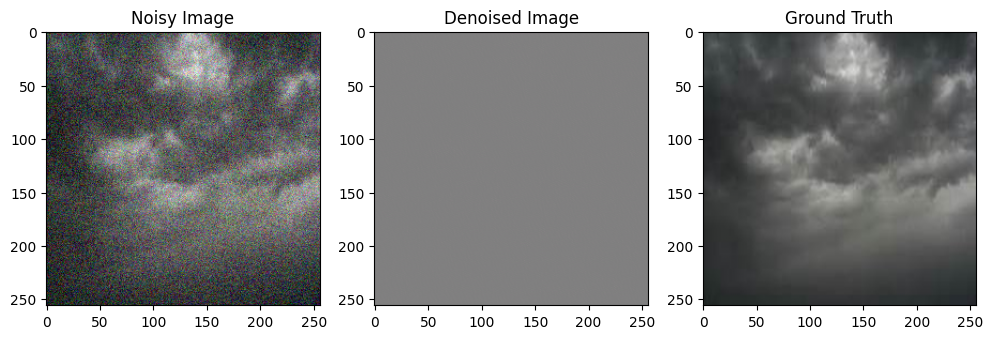

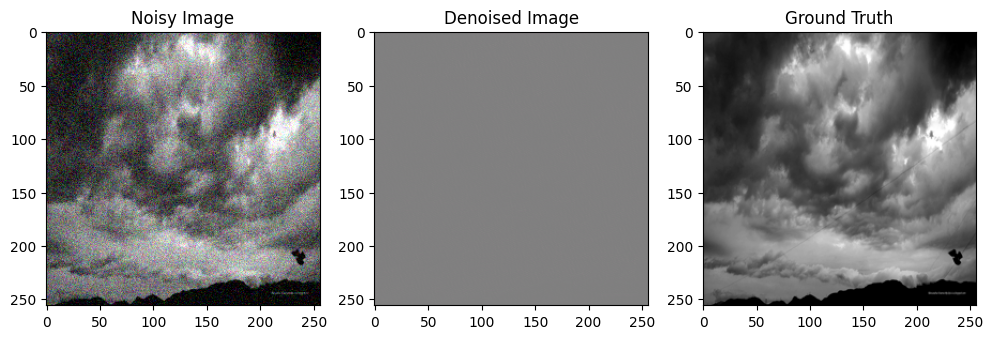

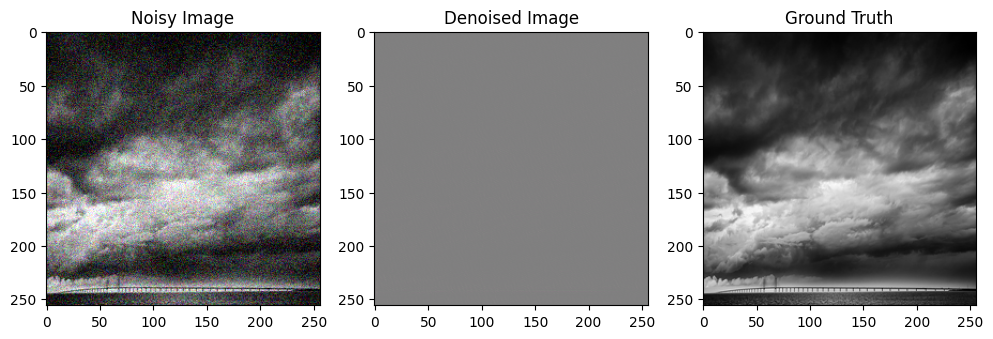

In [ ]:
def display_images(noisy, denoised, ground_truth, idx):
    plt.figure(figsize=(12, 4))

    # Display Noisy Image
    plt.subplot(1, 3, 1)
    plt.imshow(noisy[idx])
    plt.title("Noisy Image")

    # Display Denoised Image
    plt.subplot(1, 3, 2)
    plt.imshow(denoised[idx])
    plt.title("Denoised Image")

    # Display Ground Truth
    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth[idx])
    plt.title("Ground Truth")

    plt.show()

# Display a few test examples
for i in range(3):
    display_images(X_test, predictions, Y_test, i)
